# Inverse design of bimaterial LCE lattice: square


## Imports

In [1]:
from morphing_lattices.optimization import ForwardProblem, OptimizationProblem
from morphing_lattices.structure import Lattice, ControlParams
from morphing_lattices.geometry import triangular_lattice_points, triangular_lattice_connectivity
from morphing_lattices.plotting import plot_lattice, generate_animation
from morphing_lattices.utils import save_data, load_data
import pandas as pd
import numpy as np
import jax.numpy as jnp
from jax._src.config import config
config.update("jax_enable_x64", True)  # enable float64 type
from pathlib import Path
import matplotlib.pyplot as plt
%matplotlib widget
plt.style.use(["science", "grid"])


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


## Import experimental material params


In [2]:
exp_actuation_strain = pd.read_csv(
    '../exp/mechanical_data/20230512_HTNI_LTNI_actuationstrains_highgranularityTemp3355.csv'
).drop(['Unnamed: 3'], axis=1)
exp_modulus_fine = pd.read_csv(
    '../exp/mechanical_data/youngs_mod_LCEstrips_DataForBertoldiGroup_updated202307.csv'
)
exp_modulus_fine.columns = [
    'Temp',
    'LTNI_avg_young',
    'LTNI_stdev',
    'HTNI_avg_young',
    'HTNI_stdev',
]
exp_modulus_fine.drop([0, 1], inplace=True)
exp_modulus_fine = exp_modulus_fine.reset_index(drop=True)

HTNI_stretch_data = exp_actuation_strain[
    ['temp [C]', 'AVG HTNI', 'STD HTNI']
].astype(float)
LTNI_stretch_data = exp_actuation_strain[
    ['temp [C]', 'AVG LTNI', 'STD LTNI']
].astype(float)
HTNI_modulus_data_fine = exp_modulus_fine[
    ['Temp', 'HTNI_avg_young']
].astype(float)
LTNI_modulus_data_fine = exp_modulus_fine[
    ['Temp', 'LTNI_avg_young']
].astype(float)


def HTNI_stretch(temperature):
    return jnp.interp(temperature, jnp.array(HTNI_stretch_data['temp [C]']), jnp.array(HTNI_stretch_data['AVG HTNI']))


def LTNI_stretch(temperature):
    return jnp.interp(temperature, jnp.array(LTNI_stretch_data['temp [C]']), jnp.array(LTNI_stretch_data['AVG LTNI']))


def HTNI_young_fit_fine(temperature):
    return jnp.interp(temperature, jnp.array(HTNI_modulus_data_fine['Temp']), jnp.array(HTNI_modulus_data_fine['HTNI_avg_young']))


def LTNI_young_fit_fine(temperature):
    return jnp.interp(temperature, jnp.array(LTNI_modulus_data_fine['Temp']), jnp.array(LTNI_modulus_data_fine['LTNI_avg_young']))

## Optimization problem

### Temperature evolution

In [3]:
sampled_temperatures = jnp.array([
    22, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115, 120, 125, 130
])

simulation_time = 9000.  # s
sampled_times = jnp.linspace(0, simulation_time, sampled_temperatures.shape[0])


def temperature_fn(t):
    return jnp.interp(t, sampled_times, sampled_temperatures)


def young_1_fn(t):
    return HTNI_young_fit_fine(temperature_fn(t))


def young_2_fn(t):
    return LTNI_young_fit_fine(temperature_fn(t))


def thermal_strain_1_fn(t):
    return (HTNI_stretch(temperature_fn(t))-1.)*0.8


def thermal_strain_2_fn(t):
    return (LTNI_stretch(temperature_fn(t))-1.)*0.7

### Forward problem

(<Figure size 500x500 with 1 Axes>, <Axes: title={'center': 'Lattice'}>)

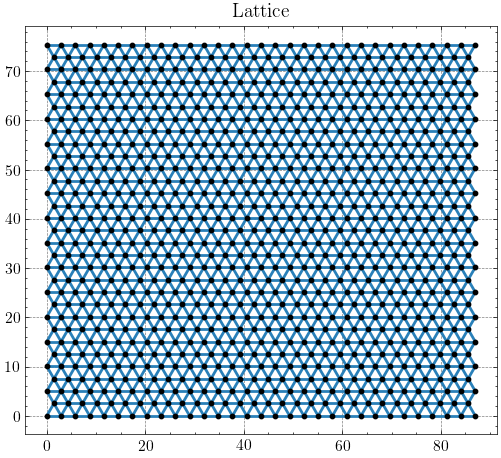

In [4]:
n1 = 30
n2 = 30
spacing = 2.9  # mm
points = triangular_lattice_points(n1=n1, n2=n2, spacing=spacing)
connectivity, horiz_bonds_even, horiz_bonds_odd, right_lean_even, right_lean_odd, left_lean_even, left_lean_odd = triangular_lattice_connectivity(
    n1=n1,
    n2=n2
)

n_points = points.shape[0]
n_bonds = connectivity.shape[0]

control_params = ControlParams(
    reference_points=points,  # mm
    young=jnp.ones(n_bonds),  # MPa
    area=jnp.ones(n_bonds)*(4*0.125**2),  # mm^2
    thermal_strain=-0.25*jnp.ones(n_bonds),
    damping=0.03*jnp.ones((n_points, 2)),
    masses=1.*jnp.ones((n_points, 2)),
    # NOTE: This is the initial guess for the material distribution
    # jnp.linspace(0, 1, n_bonds),  # NOTE: 0 means HTNI, 1 means LTNI
    phase=0.5*jnp.ones(n_bonds),
)
lattice = Lattice(
    connectivity=connectivity,
    control_params=control_params
)
problem = ForwardProblem(
    lattice=lattice,
    simulation_time=simulation_time,
    n_timepoints=sampled_temperatures.shape[0],
)
problem.setup(
    young_1_fn=young_1_fn,
    young_2_fn=young_2_fn,
    thermal_strain_1_fn=thermal_strain_1_fn,
    thermal_strain_2_fn=thermal_strain_2_fn,
    temperature_fn=temperature_fn,
)
plot_lattice(lattice=lattice, figsize=(5, 5), annotate=False, node_size=10)

### Target points

In [5]:
# Select nodes on the boundary
bottom_edge_ids = jnp.arange(0, n1)[::2]
right_edge_ids = jnp.arange(n1, n_points-1, 2*n1+1)
top_edge_ids = jnp.arange(n_points-n1, n_points, 1)[::-1][::2]
left_edge_ids = jnp.arange(2*n1+1, n_points, 2*n1+1)[::-1]
target_points_ids = jnp.concatenate([
    bottom_edge_ids,
    right_edge_ids,
    top_edge_ids,
    left_edge_ids,
])
# lattice.control_params.reference_points[jnp.roll(target_points_ids, -n1-n2//4-1)]

optimization_name = "circle_4_pointed_star"
# Generate points on a circle starting from reference points
center = lattice.control_params.reference_points.mean(axis=0)
thetas = jnp.arctan2(lattice.control_params.reference_points[target_points_ids, 1]-center[1], lattice.control_params.reference_points[target_points_ids, 0]-center[0])
# thetas = jnp.linspace(thetas[0], thetas[0]+2*jnp.pi, thetas.shape[0])
target1_points= jnp.array([
    center[0] + n1*spacing/2*jnp.cos(thetas),
    center[1] + n1*spacing/2*jnp.sin(thetas)
]).T
# Generate a 4-pointed star
spikeness = 0.1
x_size = lattice.control_params.reference_points.max(axis=0)[0] - lattice.control_params.reference_points.min(axis=0)[0]
y_size = lattice.control_params.reference_points.max(axis=0)[1] - lattice.control_params.reference_points.min(axis=0)[1]
bottom_points = lattice.control_params.reference_points[bottom_edge_ids] + jnp.concatenate([
    jnp.linspace(0, 1, bottom_edge_ids.shape[0]//2+1)[:, None]*jnp.array([0, 1]),
    jnp.linspace(1, 0, bottom_edge_ids.shape[0]//2)[:, None]*jnp.array([0, 1]),
], axis=0)*x_size*spikeness
right_points = lattice.control_params.reference_points[right_edge_ids] + jnp.concatenate([
    jnp.linspace(0, 1, right_edge_ids.shape[0]//2+1)[:, None]*jnp.array([-1, 0]),
    jnp.linspace(1, 0, right_edge_ids.shape[0]//2)[:, None]*jnp.array([-1, 0]),
], axis=0)*y_size*spikeness
top_points = lattice.control_params.reference_points[top_edge_ids] + jnp.concatenate([
    jnp.linspace(0, 1, top_edge_ids.shape[0]//2+1)[:, None]*jnp.array([0, -1]),
    jnp.linspace(1, 0, top_edge_ids.shape[0]//2)[:, None]*jnp.array([0, -1]),
], axis=0)*x_size*spikeness
left_points = lattice.control_params.reference_points[left_edge_ids] + jnp.concatenate([
    jnp.linspace(0, 1, left_edge_ids.shape[0]//2+1)[:, None]*jnp.array([1, 0]),
    jnp.linspace(1, 0, left_edge_ids.shape[0]//2)[:, None]*jnp.array([1, 0]),
], axis=0)*y_size*spikeness
target2_points = jnp.concatenate([
    bottom_points,
    right_points,
    top_points,
    left_points,
], axis=0)


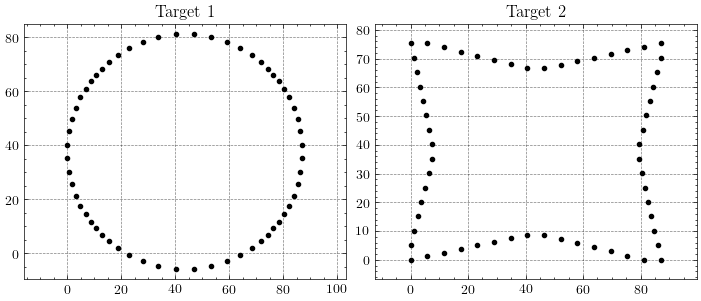

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7, 3), constrained_layout=True)
ax1.plot(target1_points[:, 0], target1_points[:, 1],
         'o', color='k', markersize=3)
ax2.plot(target2_points[:, 0], target2_points[:, 1],
         'o', color='k', markersize=3)
ax1.set_title('Target 1')
ax2.set_title('Target 2')
ax1.axis('equal')
ax2.axis('equal')

save_opt_information = True
if save_opt_information:
    out_path = Path(f"{optimization_name}/target_shapes.png")
    # Make sure parents directories exist
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(str(out_path), dpi=200)

In [7]:
optimization = OptimizationProblem(
    forward_problem=problem,
    target1_points=target1_points,
    target2_points=target2_points,
    target_points_ids=target_points_ids,
    target1_temperature=70.,
    target2_temperature=130.
)

### Sweep weights

In [8]:
# # Sweep over weights: w_1: 1→0, w_2: 0→1
# n_weights = 5
# weights_sweep = jnp.array([
#     jnp.linspace(1, 0, n_weights),
#     jnp.linspace(0, 1, n_weights),
# ]).T
# for weights in weights_sweep:
#     optimization = OptimizationProblem(
#         forward_problem=problem,
#         target1_points=target1_points,
#         target2_points=target2_points,
#         target_points_ids=target_points_ids,
#         target1_temperature=70.,
#         target2_temperature=130.,
#         weights=weights
#     )
#     optimization.run_optimization_nlopt(
#         n_iterations=50,
#         lower_bound=0.,
#         upper_bound=1.,
#     )
#     # Save optimization data
#     save_data(
#         f"../data/inverse_design/{optimization_name}/pareto/weights_{weights[0]:.2f}_{weights[1]:.2f}.pkl",
#         optimization.to_data(),
#     )

### Pareto front

(-0.013252150169715652,
 0.2782951535640287,
 -0.01385723856352758,
 0.2910020098340792)

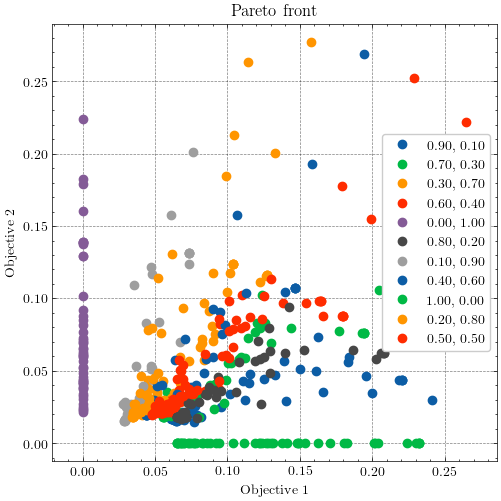

In [38]:
sweep_files = Path(
    f"../data/inverse_design/{optimization_name}/pareto/"
).glob("*.pkl")
fig, axes = plt.subplots(figsize=(5, 5), constrained_layout=True)
for file in sweep_files:
    opt = OptimizationProblem.from_data(load_data(file))
    axes.plot(
        opt.individual_objective_values[:, 0],
        opt.individual_objective_values[:, 1],
        'o',
        # color="gray",
        label=f"{opt.weights[0]:.2f}, {opt.weights[1]:.2f}"
    )
axes.set_xlabel('Objective 1')
axes.set_ylabel('Objective 2')
axes.legend()
axes.set_title('Pareto front')
axes.axis('equal')

#### Best equi-peformance design


In [30]:
optimization = OptimizationProblem.from_data(
    load_data(
        f"../data/inverse_design/{optimization_name}/pareto/weights_0.10_0.90.pkl"
    )
)

### Run optimization


In [32]:
optimization.run_optimization_nlopt(
    n_iterations=50,
    # max_time=60,
    lower_bound=0.,
    upper_bound=1.,
)

Iteration: 1
Objective = 0.03662583240890064
MMA dual converged in 2 iterations to g=0.0366249:
Iteration: 2
Objective = 0.03662395103673391
MMA outer iteration: rho -> 0.1
MMA dual converged in 2 iterations to g=0.0366146:
Iteration: 3
Objective = 0.03660517108008257
MMA outer iteration: rho -> 0.01
                 MMA sigma[0] -> 0.6
MMA dual converged in 2 iterations to g=0.0364747:
Iteration: 4
Objective = 0.036339438266744385
MMA outer iteration: rho -> 0.001
                 MMA sigma[0] -> 0.72
MMA dual converged in 2 iterations to g=0.0348463:
Iteration: 5
Objective = 0.03307196892593425
MMA outer iteration: rho -> 0.0001
                 MMA sigma[0] -> 0.864
MMA dual converged in 2 iterations to g=0.0243743:
Iteration: 6
Objective = 0.019799283956332875
MMA outer iteration: rho -> 1e-05
                 MMA sigma[0] -> 1.0368
MMA dual converged in 2 iterations to g=-0.0119952:
Iteration: 7
Objective = 0.11596709984392693
MMA inner iteration: rho -> 0.0001
MMA dual converged 

### Plot the objective values

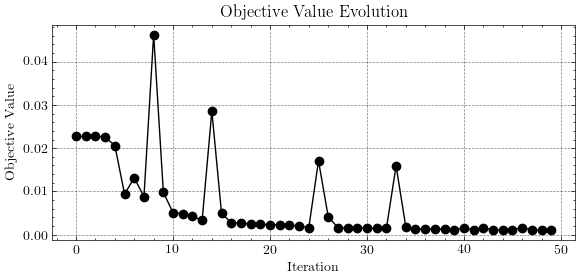

In [31]:
plt.figure(figsize=(6, 3))
plt.plot(optimization.objective_values, color='k', marker='o')
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Objective Value Evolution')
plt.savefig(f"{optimization_name}/objective_value_evolution.png", dpi=200)
plt.tight_layout()


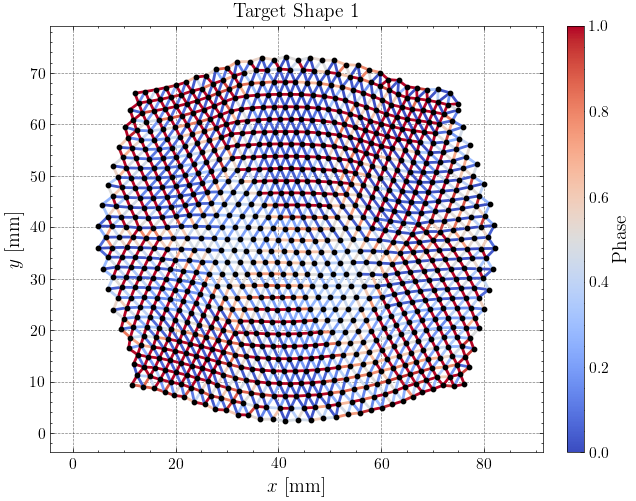

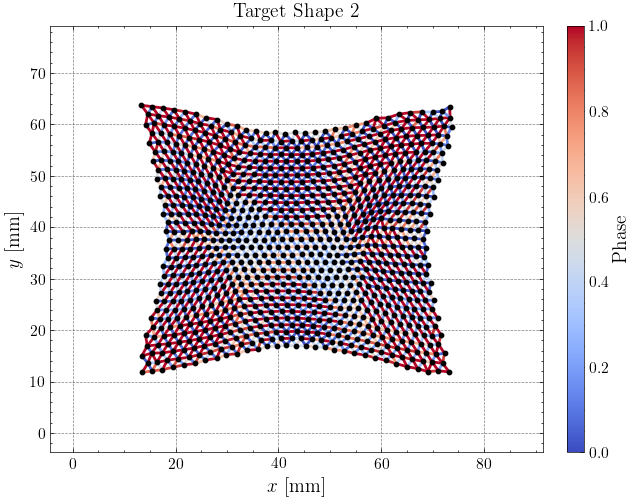

In [32]:
plot_lattice(
    lattice=lattice,
    title='Target Shape 1',
    displacement=optimization.best_response[10, 0],
    bond_values=optimization.best_control_params.phase,
    figsize=(7, 5),
    legend_label="Phase",
    node_size=10,
    x_label="$x$ [mm]",
    y_label="$y$ [mm]",
)

if save_opt_information:
    out_path = Path(f"{optimization_name}/target_shape1_phase_vals.png")
    # Make sure parents directories exist
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(str(out_path), dpi=200)

plot_lattice(
    lattice=lattice,
    title='Target Shape 2',
    displacement=optimization.best_response[-1, 0],
    bond_values=optimization.best_control_params.phase,
    figsize=(7, 5),
    legend_label="Phase",
    node_size=10,
    x_label="$x$ [mm]",
    y_label="$y$ [mm]",
)

if save_opt_information:
    out_path = Path(f"{optimization_name}/target_shape2_phase_vals.png")
    # Make sure parents directories exist
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(str(out_path), dpi=200)

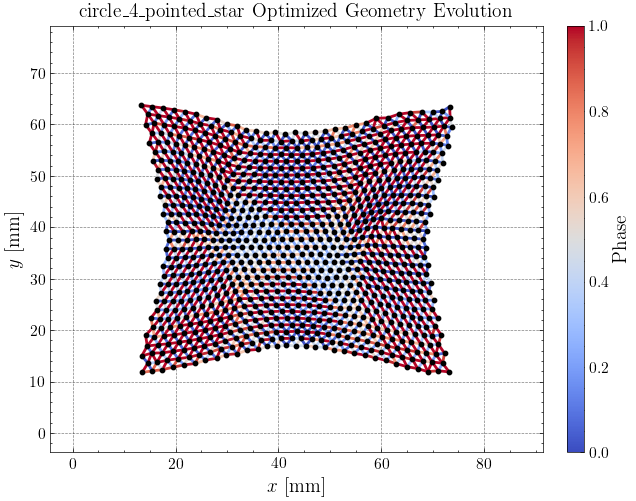

In [33]:
generate_animation(
    lattice=lattice,
    solution=optimization.best_response,
    out_filename=f'{optimization_name}/animation',
    frame_range=optimization.best_response.shape[0],
    figsize=(7, 5),
    x_label="$x$ [mm]",
    y_label="$y$ [mm]",
    title=f'{optimization_name} Optimized Geometry Evolution',
    node_size=10,
    bond_values=jnp.array(
        [optimization.best_control_params.phase]*optimization.best_response.shape[0]),
    legend_label="Phase",
)

### Impose Discrete Phase Values Corresponding to HTNI and LTNI LCE

In [34]:
phase_threshold = 0.5
discrete_phases = jnp.where(optimization.best_control_params.phase > phase_threshold, 1, 0)

discrete_phase_solution, discrete_control_params = problem.solve(discrete_phases)

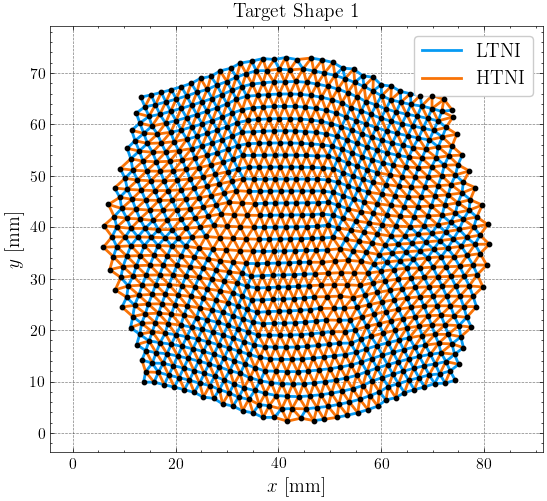

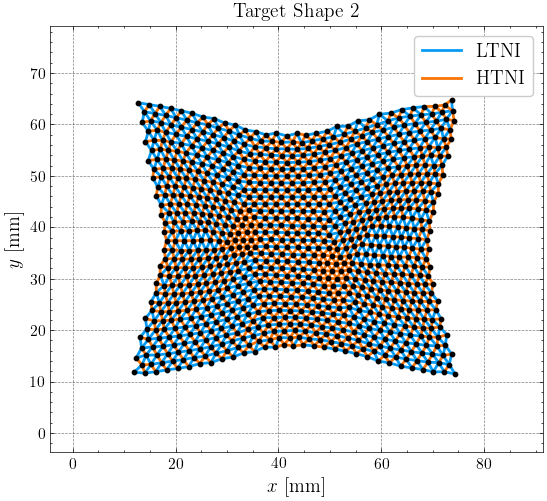

In [35]:
plot_lattice(
    lattice=lattice,
    title='Target Shape 1',
    displacement=discrete_phase_solution[10, 0],
    bond_color=np.where(discrete_phases > phase_threshold,
                        "#069AF3", "#F97306"),
    legend_colors=("#069AF3", "#F97306"),
    legend_labels=("LTNI", "HTNI"),
    figsize=(7, 5),
    node_size=10,
    x_label="$x$ [mm]",
    y_label="$y$ [mm]",
)

if save_opt_information:
    out_path = Path(
        f"{optimization_name}/LCE_labeled_target_shape1_phase_vals.png")
    # Make sure parents directories exist
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(str(out_path), dpi=200)

plot_lattice(
    lattice=lattice,
    title='Target Shape 2',
    displacement=discrete_phase_solution[-1, 0],
    bond_color=np.where(discrete_phases > phase_threshold,
                        "#069AF3", "#F97306"),
    legend_colors=("#069AF3", "#F97306"),
    legend_labels=("LTNI", "HTNI"),
    figsize=(7, 5),
    node_size=10,
    x_label="$x$ [mm]",
    y_label="$y$ [mm]",
)

if save_opt_information:
    out_path = Path(
        f"{optimization_name}/LCE_labeled_target_shape2_phase_vals.png")
    # Make sure parents directories exist
    out_path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(str(out_path), dpi=200)

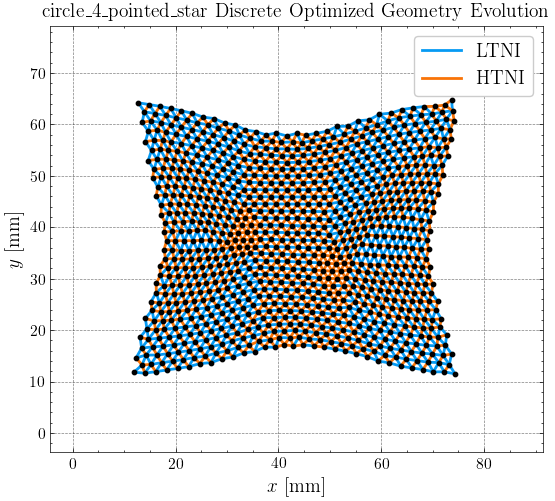

In [36]:
generate_animation(
    lattice=lattice,
    solution=discrete_phase_solution,
    out_filename=f'{optimization_name}/discrete_animation',
    frame_range=discrete_phase_solution.shape[0],
    title=f'{optimization_name} Discrete Optimized Geometry Evolution',
    figsize=(7, 5),
    node_size=10,
    x_label="$x$ [mm]",
    y_label="$y$ [mm]",
    bond_color=np.where(discrete_phases > phase_threshold,
                        "#069AF3", "#F97306"),
    legend_colors=("#069AF3", "#F97306"),
    legend_labels=("LTNI", "HTNI"),
)